In [1]:
!nvidia-smi

Mon Feb 12 16:49:02 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   39C    P8    23W / 320W |   1843MiB / 16376MiB |     11%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import wandb

module_path='/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/'
if module_path not in sys.path:
    sys.path.append(module_path)

from cohort_loader import *

from model import *
from pytorch_metric_learning import losses
import torch.optim as optim

c:\Users\DAHS\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mimic_data_dir = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Case Labeling/mimic_analysis.csv.gz'
eicu_data_dir = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Case Labeling/eicu_analysis.csv.gz'

In [4]:
mimic_event = EventDataset(data_path=mimic_data_dir, data_type='mimic',seed=9040)
loader_event_out = DataLoader(mimic_event, batch_size=32, shuffle=False, drop_last=False)

In [5]:
# eicu_train = TableDataset(data_path=eicu_data_dir, data_type='eicu',mode='valid',seed=9040)
# loader_eicu_out = DataLoader(eicu_train, batch_size=32, shuffle=False, drop_last=False)

mimic_train = TableDataset(data_path=mimic_data_dir, data_type='mimic',mode='train',seed=9040)
loader_trn_out = DataLoader(mimic_train, batch_size=32, shuffle=False, drop_last=False)

# mimic_valid = TableDataset(data_path=mimic_data_dir, data_type='mimic',mode='valid',seed=9040)
# loader_val_out = DataLoader(mimic_valid, batch_size=32, shuffle=False, drop_last=False)

========== 데이터셋 분할 정보 ==========
데이터셋 비율: 학습 = 0.90, 테스트 = 0.10
학습셋 클래스 비율: Case
1.0    473941
2.0      5128
3.0     11145
4.0     19613
Name: count, dtype: int64
테스트셋 클래스 비율: Case
1.0    53103
2.0      512
3.0      873
4.0     1590
Name: count, dtype: int64
--------------------------------------
========== 클래스 비율 ==========
학습셋 클래스 비율: 0.93:0.01:0.02:0.04
테스트셋 클래스 비율: 0.95:0.01:0.02:0.03
--------------------------------------
========== 환자 및 체류 정보 ==========
학습셋 환자 수: 2907
테스트셋 환자 수: 329
학습셋 체류 수: 2961
테스트셋 체류 수: 330
--------------------------------------
========== 실험 설정 ==========
분할 시드: 9040
학습 비율: 0.9
임계값: 0.05
--------------------------------------
========== 실행 결과 ==========
총 소요 시간(초): 0.37
시도한 시행 횟수: 0


In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

SEED = 7759
seed_everything(seed = SEED)

In [7]:
device            = torch.device('cuda:0')

In [8]:
card_categories = []
for col in mimic_train.df_cat.columns:
    card_categories.append(mimic_train.df_cat[col].nunique())

model = FTTransformer(categories=card_categories,
num_continuous=157,
dim=78,
depth=4,
heads=5,
dim_head=52,
num_special_tokens = 2,
attn_dropout=0.4585,
ff_dropout=0.5641).to(device)

In [9]:
checkpoint = torch.load("Contrastive_Embedding_Net_ftt(0212_best_batch=64).pt")
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [10]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import gc
from timeit import default_timer as timer

gc.collect()

def make_embeded_df_valid(model_name):

    print('Start Getting the latent space vector (Valid sample)')
    start = timer()

    model_name.eval()
    with torch.no_grad():
        for idx, batch_data in enumerate(tqdm(loader_val_out)):
            X_num, X_cat, label = batch_data
            X_num, X_cat = X_num.to(device), X_cat.to(device)
            latent, att_valid = model_name(X_cat, X_num, True)

            ## atttnmap -> (depth,b,head,seq,seq)
            if not idx:
                cum_attn_map = np.mean(att_valid.detach().cpu().numpy(),axis = 1)
                latent_arrays = latent.detach().cpu().numpy()
        
            else:
                cum_attn_map += np.mean(att_valid.detach().cpu().numpy(),axis = 1)
                latent_arrays = np.vstack((latent_arrays,latent.detach().cpu().numpy()))


        # delete_fillna_value
        final_attn_map = cum_attn_map / len(loader_val_out)

        np.save('/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/Train/result/emb_valid_new_version.npy',latent_arrays)
        # np.save('/home/DAHS2/ECP_CONT/ECP_SCL/Visualization/result/emb_valid_new_version.npy',latent_arrays)

    end = timer()            
    print('End, Time consume (min): {}'.format((end - start)/60))  
    
    return final_attn_map

def make_embeded_df_train(model_name):

    print('Start Getting the latent space vector (Train sample)')
    start = timer()

    model_name.eval()
    with torch.no_grad():
        for idx, batch_data in enumerate(tqdm(loader_trn_out)):
            X_num, X_cat, label = batch_data
            X_num, X_cat = X_num.to(device), X_cat.to(device)
            latent, _ = model_name(X_cat, X_num, True)

            ## atttnmap -> (depth,b,head,seq,seq)
            if not idx:
                latent_arrays = latent.detach().cpu().numpy()
        
            else:
                latent_arrays = np.vstack((latent_arrays,latent.detach().cpu().numpy()))

        
        # np.save('/home/DAHS2/ECP_CONT/ECP_SCL/Visualization/result/emb_eicu_new_version.npy',latent_arrays)
        np.save('/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/Train/result/emb_train_new_version.npy',latent_arrays)
    end = timer()            
    print('End, Time consume (min): {}'.format((end - start)/60))  
    
def make_embeded_df_test(model_name):

    print('Start Getting the latent space vector (Test sample)')
    start = timer()

    model_name.eval()
    with torch.no_grad():
        for idx, batch_data in enumerate(tqdm(loader_eicu_out)):
            X_num, X_cat, label = batch_data
            X_num, X_cat = X_num.to(device), X_cat.to(device)
            latent, _ = model_name(X_cat, X_num, True)

            ## atttnmap -> (depth,b,head,seq,seq)
            if not idx:
                latent_arrays = latent.detach().cpu().numpy()
        
            else:
                latent_arrays = np.vstack((latent_arrays,latent.detach().cpu().numpy()))

        
        np.save('/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/Train/result/emb_eicu_new_version.npy',latent_arrays)
        
    end = timer()            
    print('End, Time consume (min): {}'.format((end - start)/60))  

make_embeded_df_train(model)
make_embeded_df_test(model)
valid_att = make_embeded_df_valid(model)

Start Getting the latent space vector (Train sample)


100%|██████████| 15933/15933 [09:44<00:00, 27.27it/s]


End, Time consume (min): 9.739220916666666
Start Getting the latent space vector (Test sample)


100%|██████████| 29927/29927 [29:16<00:00, 17.03it/s]


End, Time consume (min): 29.28607854833333
Start Getting the latent space vector (Valid sample)


100%|██████████| 1753/1753 [01:49<00:00, 15.95it/s]

End, Time consume (min): 1.831899198333334


In [10]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import gc
from timeit import default_timer as timer
def make_embeded_df_event(model_name):
    
    print('Start Getting the latent space vector (Train sample)')
    start = timer()

    model_name.eval()
    with torch.no_grad():
        for idx, batch_data in enumerate(tqdm(loader_event_out)):
            X_num, X_cat, label = batch_data
            X_num, X_cat = X_num.to(device), X_cat.to(device)
            latent, _ = model_name(X_cat, X_num, True)

            ## atttnmap -> (depth,b,head,seq,seq)
            if not idx:
                latent_arrays = latent.detach().cpu().numpy()
        
            else:
                latent_arrays = np.vstack((latent_arrays,latent.detach().cpu().numpy()))

        
        # np.save('/home/DAHS2/ECP_CONT/ECP_SCL/Visualization/result/emb_eicu_new_version.npy',latent_arrays)
        np.save('/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/Train/result/emb_event_new_version.npy',latent_arrays)
    end = timer()            
    print('End, Time consume (min): {}'.format((end - start)/60))  
    
make_embeded_df_event(model)   

Start Getting the latent space vector (Train sample)


100%|██████████| 23/23 [00:00<00:00, 35.15it/s]

End, Time consume (min): 0.011131010000000016


In [11]:
columns = ['CLS_Token'] + mimic_valid.df_cat.columns.tolist() + mimic_valid.df_num.columns.tolist()

In [12]:

# focus_columns는 시각화하고자 하는 특정 컬럼들의 인덱스 리스트
focus_col_name = ['HR', 'MAP', 'Lactate', 'Lactate_clearance_1h',
'Lactate_clearance_3h', 'Lactate_clearance_5h', 'cum_use_vaso','vasoactive/inotropic', 'Alkaline_phosphatase',
'BUN','Total Bilirubin', 'ALT', 'AST', 'Troponin-T', 'Creatinine','RedBloodCell', 'pH', 'Hemoglobin', 'Hematocrit',
'Mechanical_circ_support', 'MAP_change_1h', 'MAP_change_3h', 'MAP_change_5h',
'Creatinine_change_1h', 'Creatinine_change_3h', 'Creatinine_change_5h', 'ALT_change_1h', 'ALT_change_3h', 'ALT_change_5h','AST_change_1h', 'AST_change_3h', 'AST_change_5h',
'Total Bilirubin_change_1h', 'Total Bilirubin_change_3h', 'Total Bilirubin_change_5h', 'Troponin-T_change_1h', 'Troponin-T_change_3h', 'Troponin-T_change_5h']


focus_columns = [columns.index(col) for col in focus_col_name if col in columns]


# 필요한 컬럼 이름만 추출
focus_columns_names = [columns[i] for i in focus_columns]

In [13]:
ixgrid = np.ix_(focus_columns, focus_columns)

In [14]:
ixgrid[1][0]

array([ 72,  99, 126, 129, 130, 131, 135,  15, 125,  80,  95,  77, 119,
        86, 104,  78,  94, 112,  20, 136, 150, 164, 144, 158, 172, 145,
       159, 173, 146, 160, 174, 147, 161, 175, 149, 163, 177])

In [15]:
col_indx =[72,  99, 126, 129, 130, 131, 135,  15, 125,  80,  95,  77, 119,
        86, 104,  78,  94, 112,  20, 136, 150, 164, 144, 158, 172, 145,
       159, 173, 146, 160, 174, 147, 161, 175, 149, 163, 177]

In [15]:
len(col_indx)

37

In [16]:
len(focus_col_name)

38

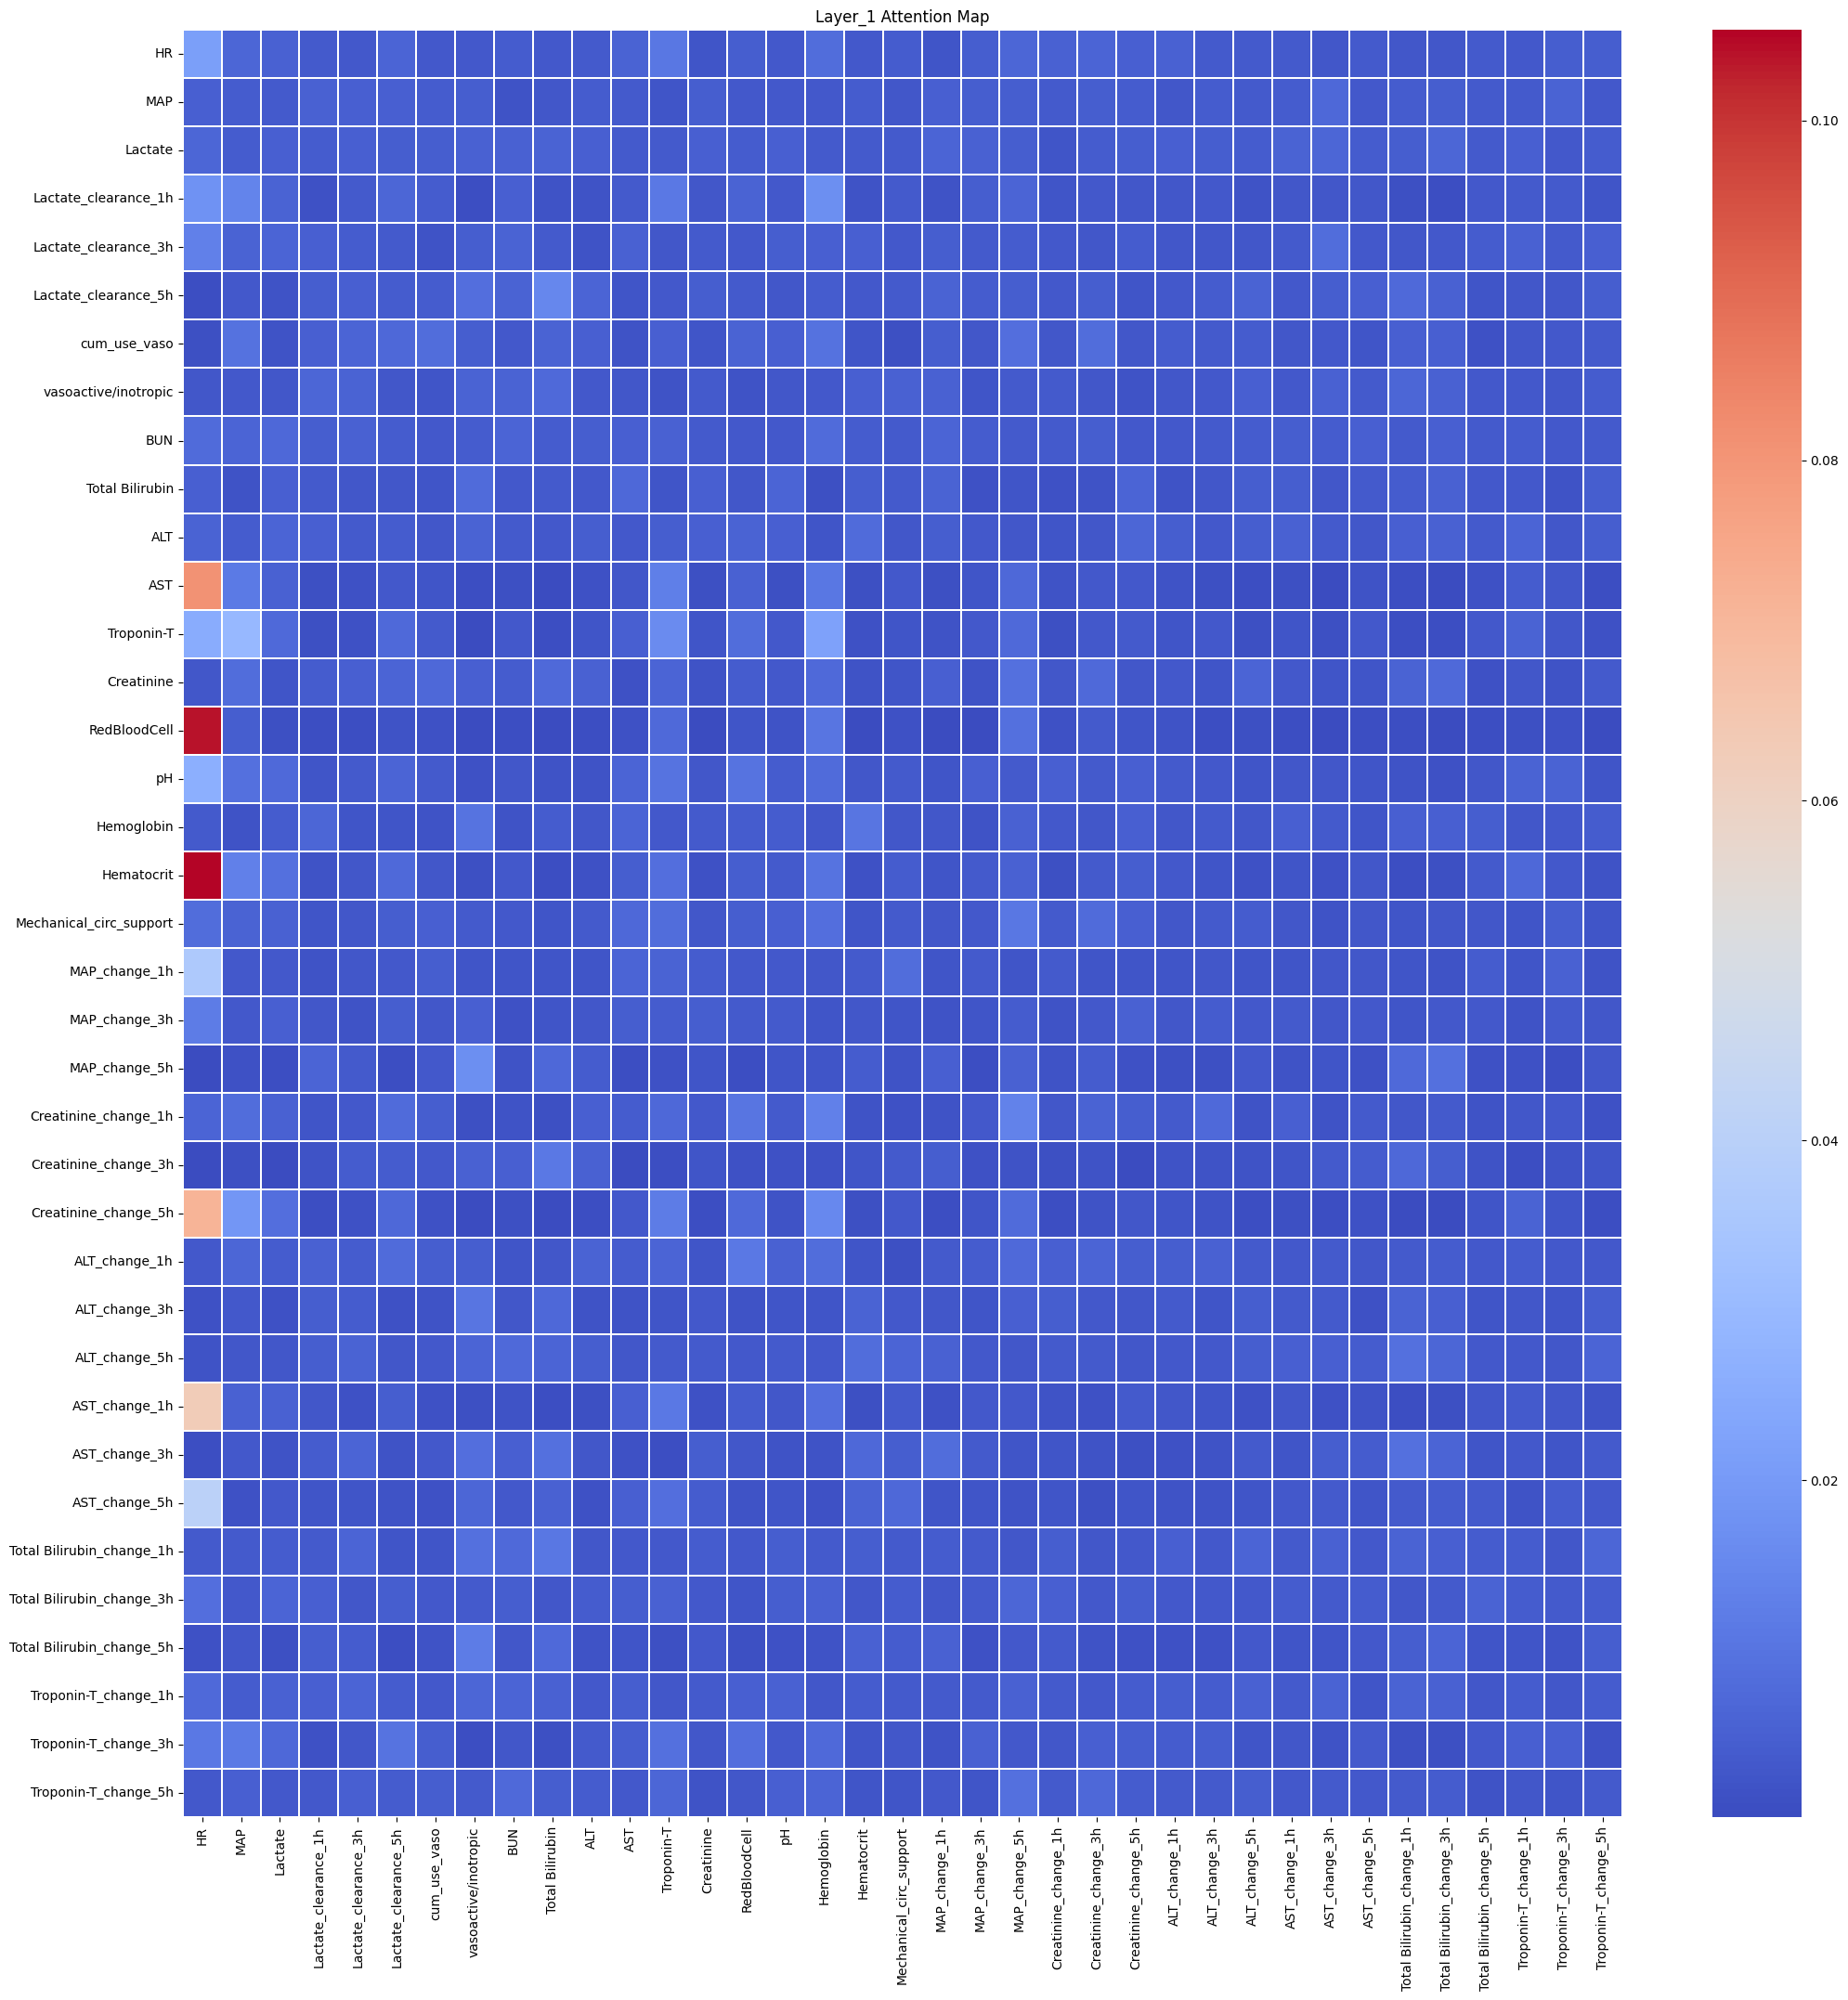

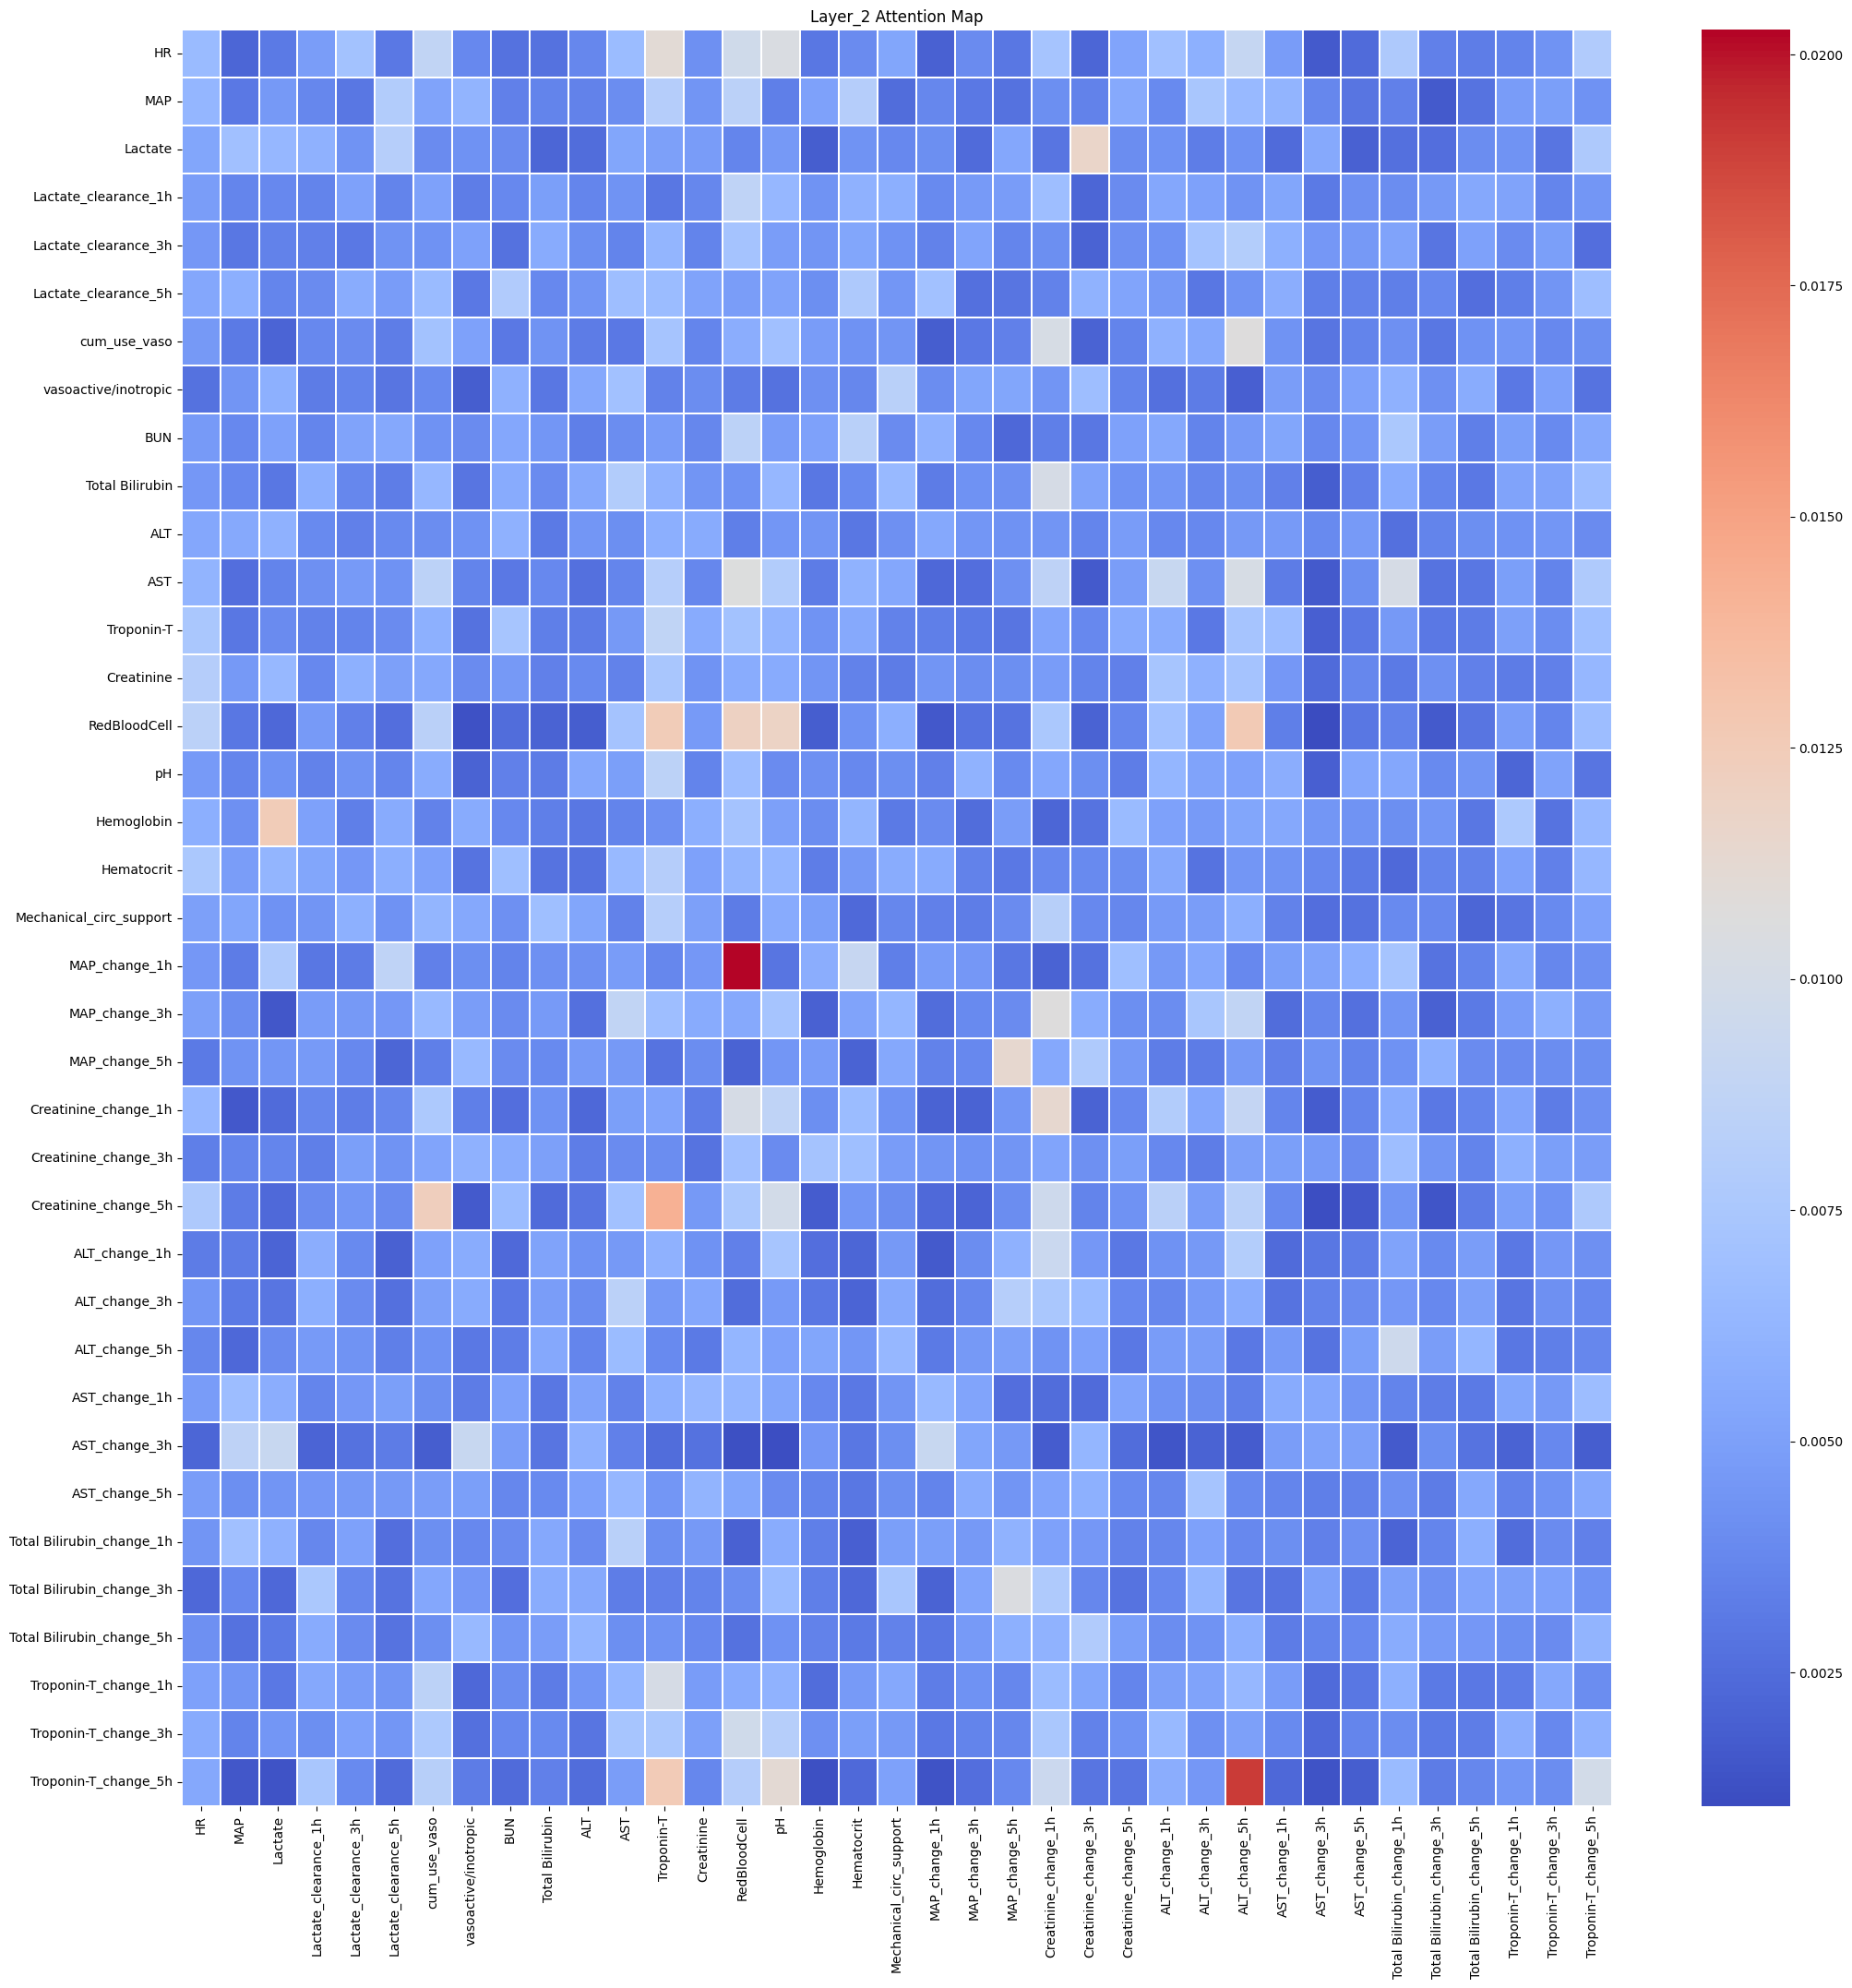

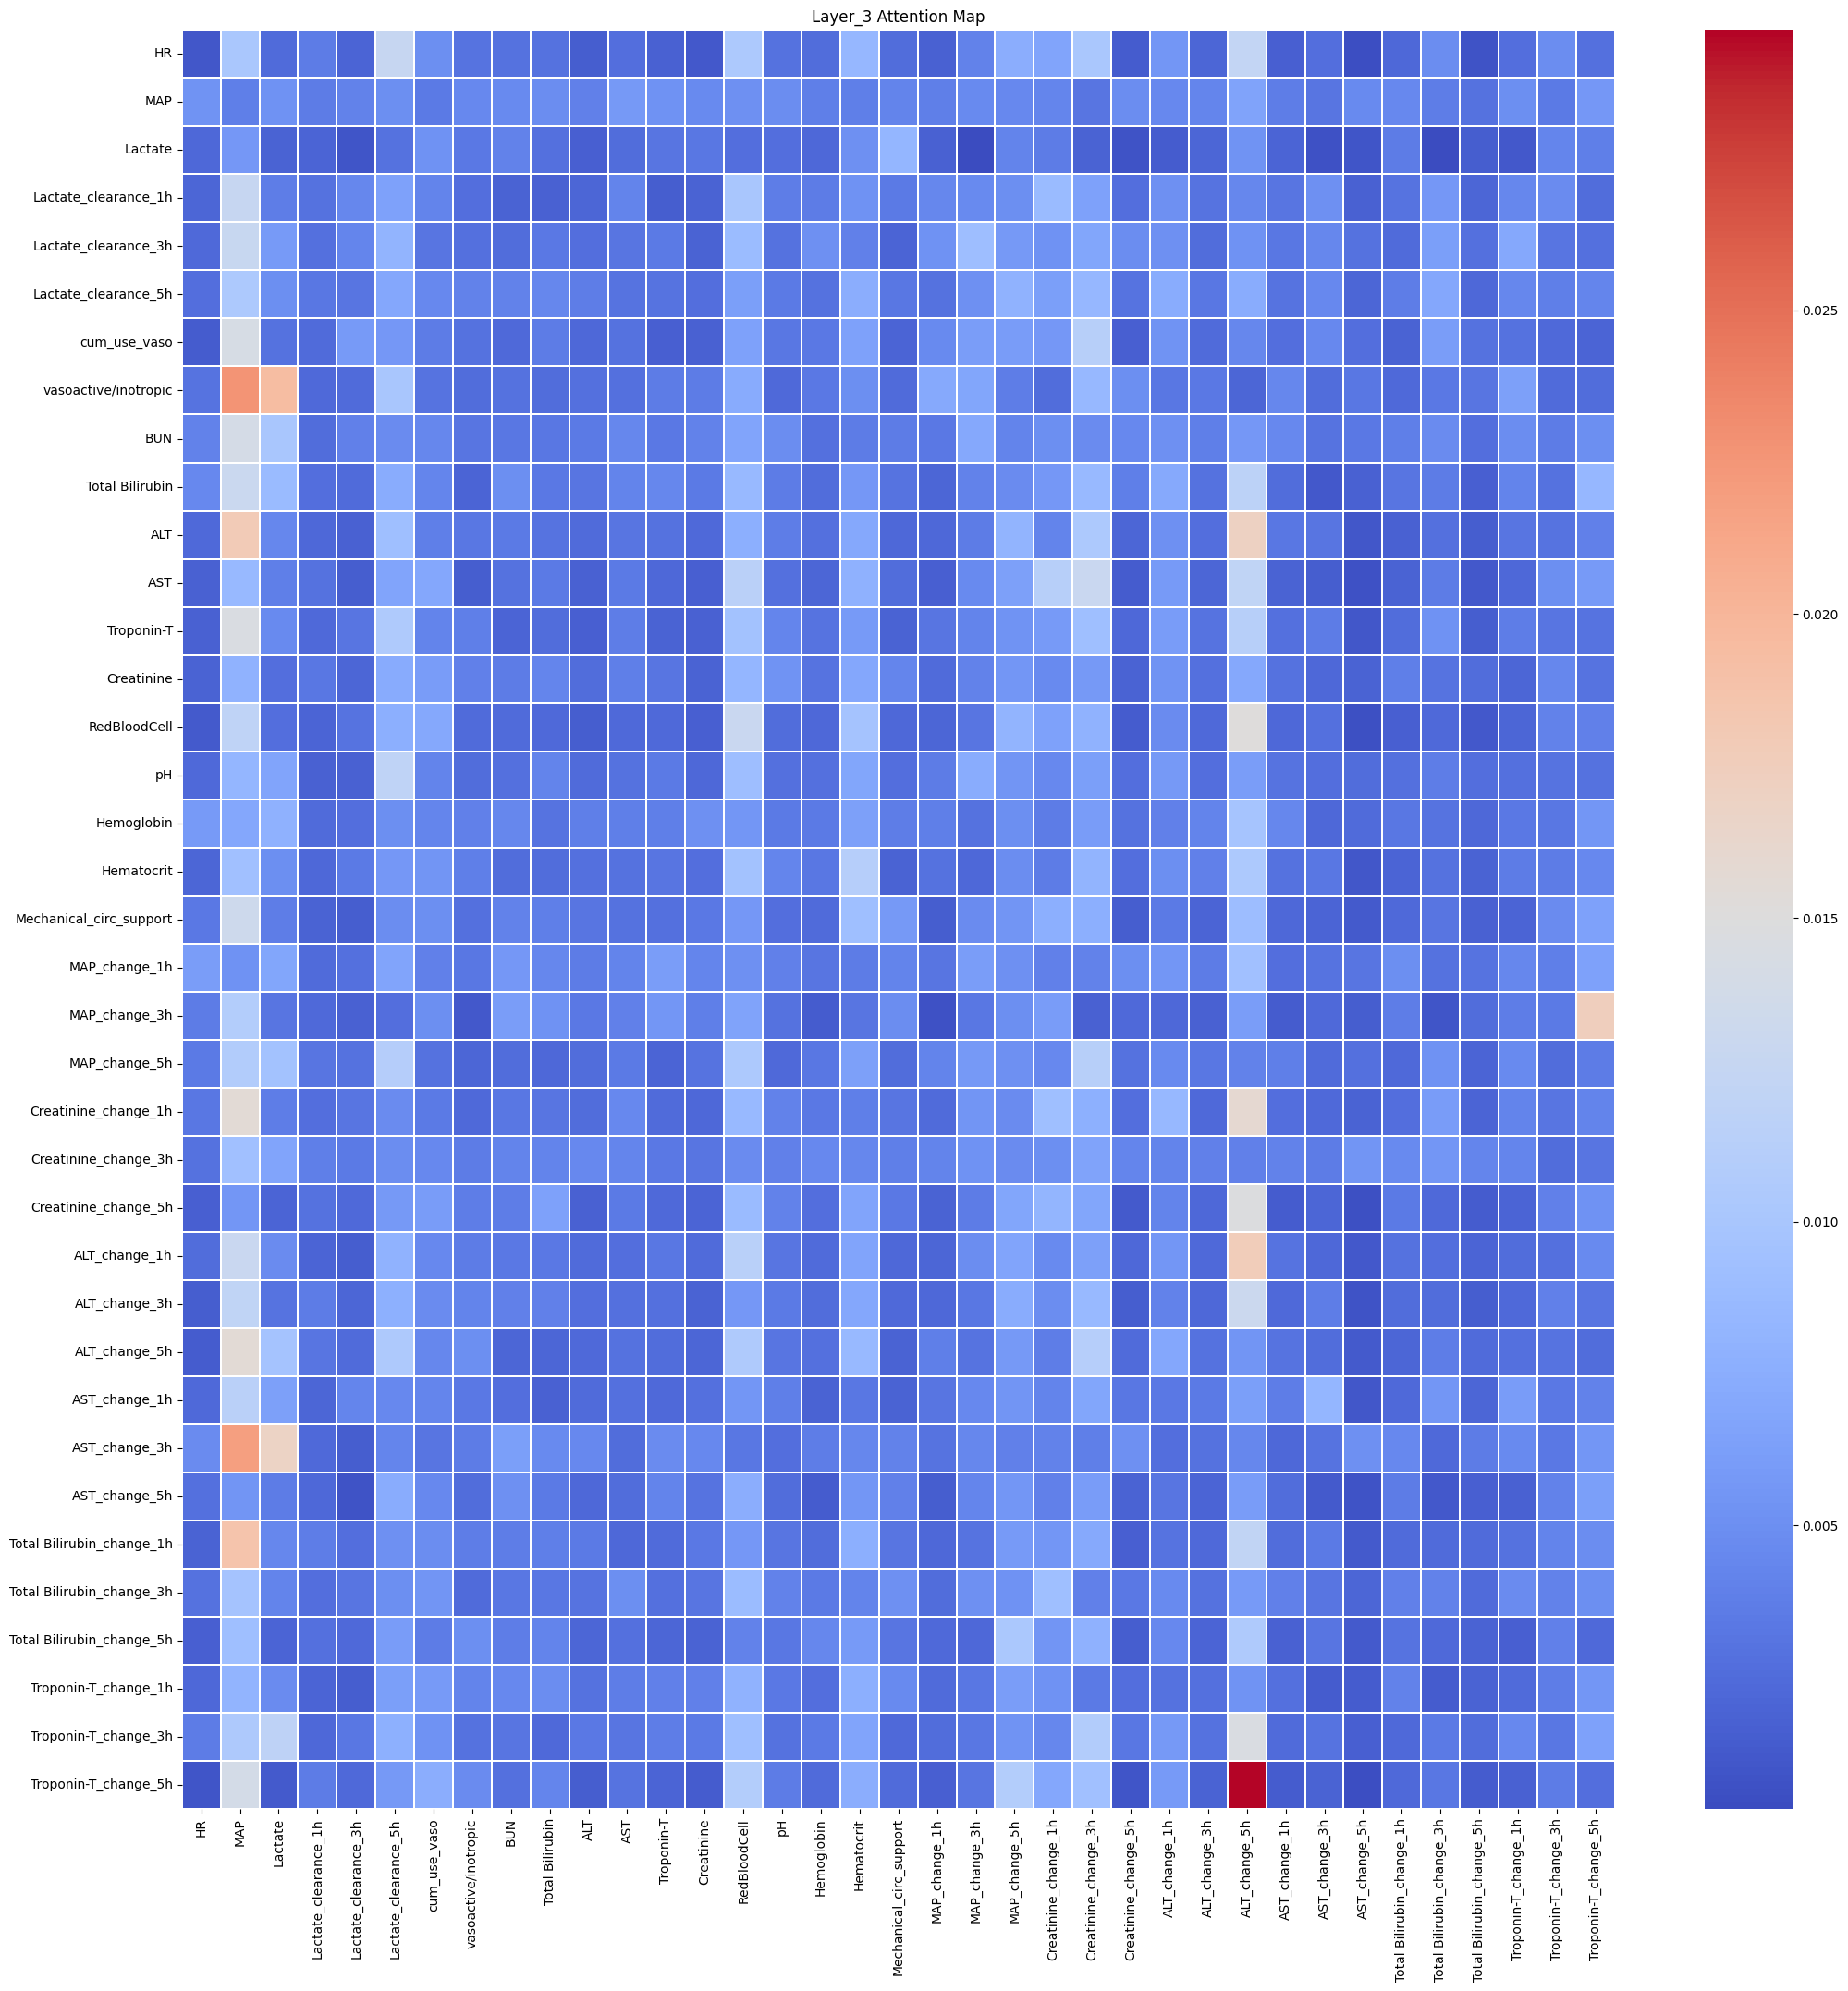

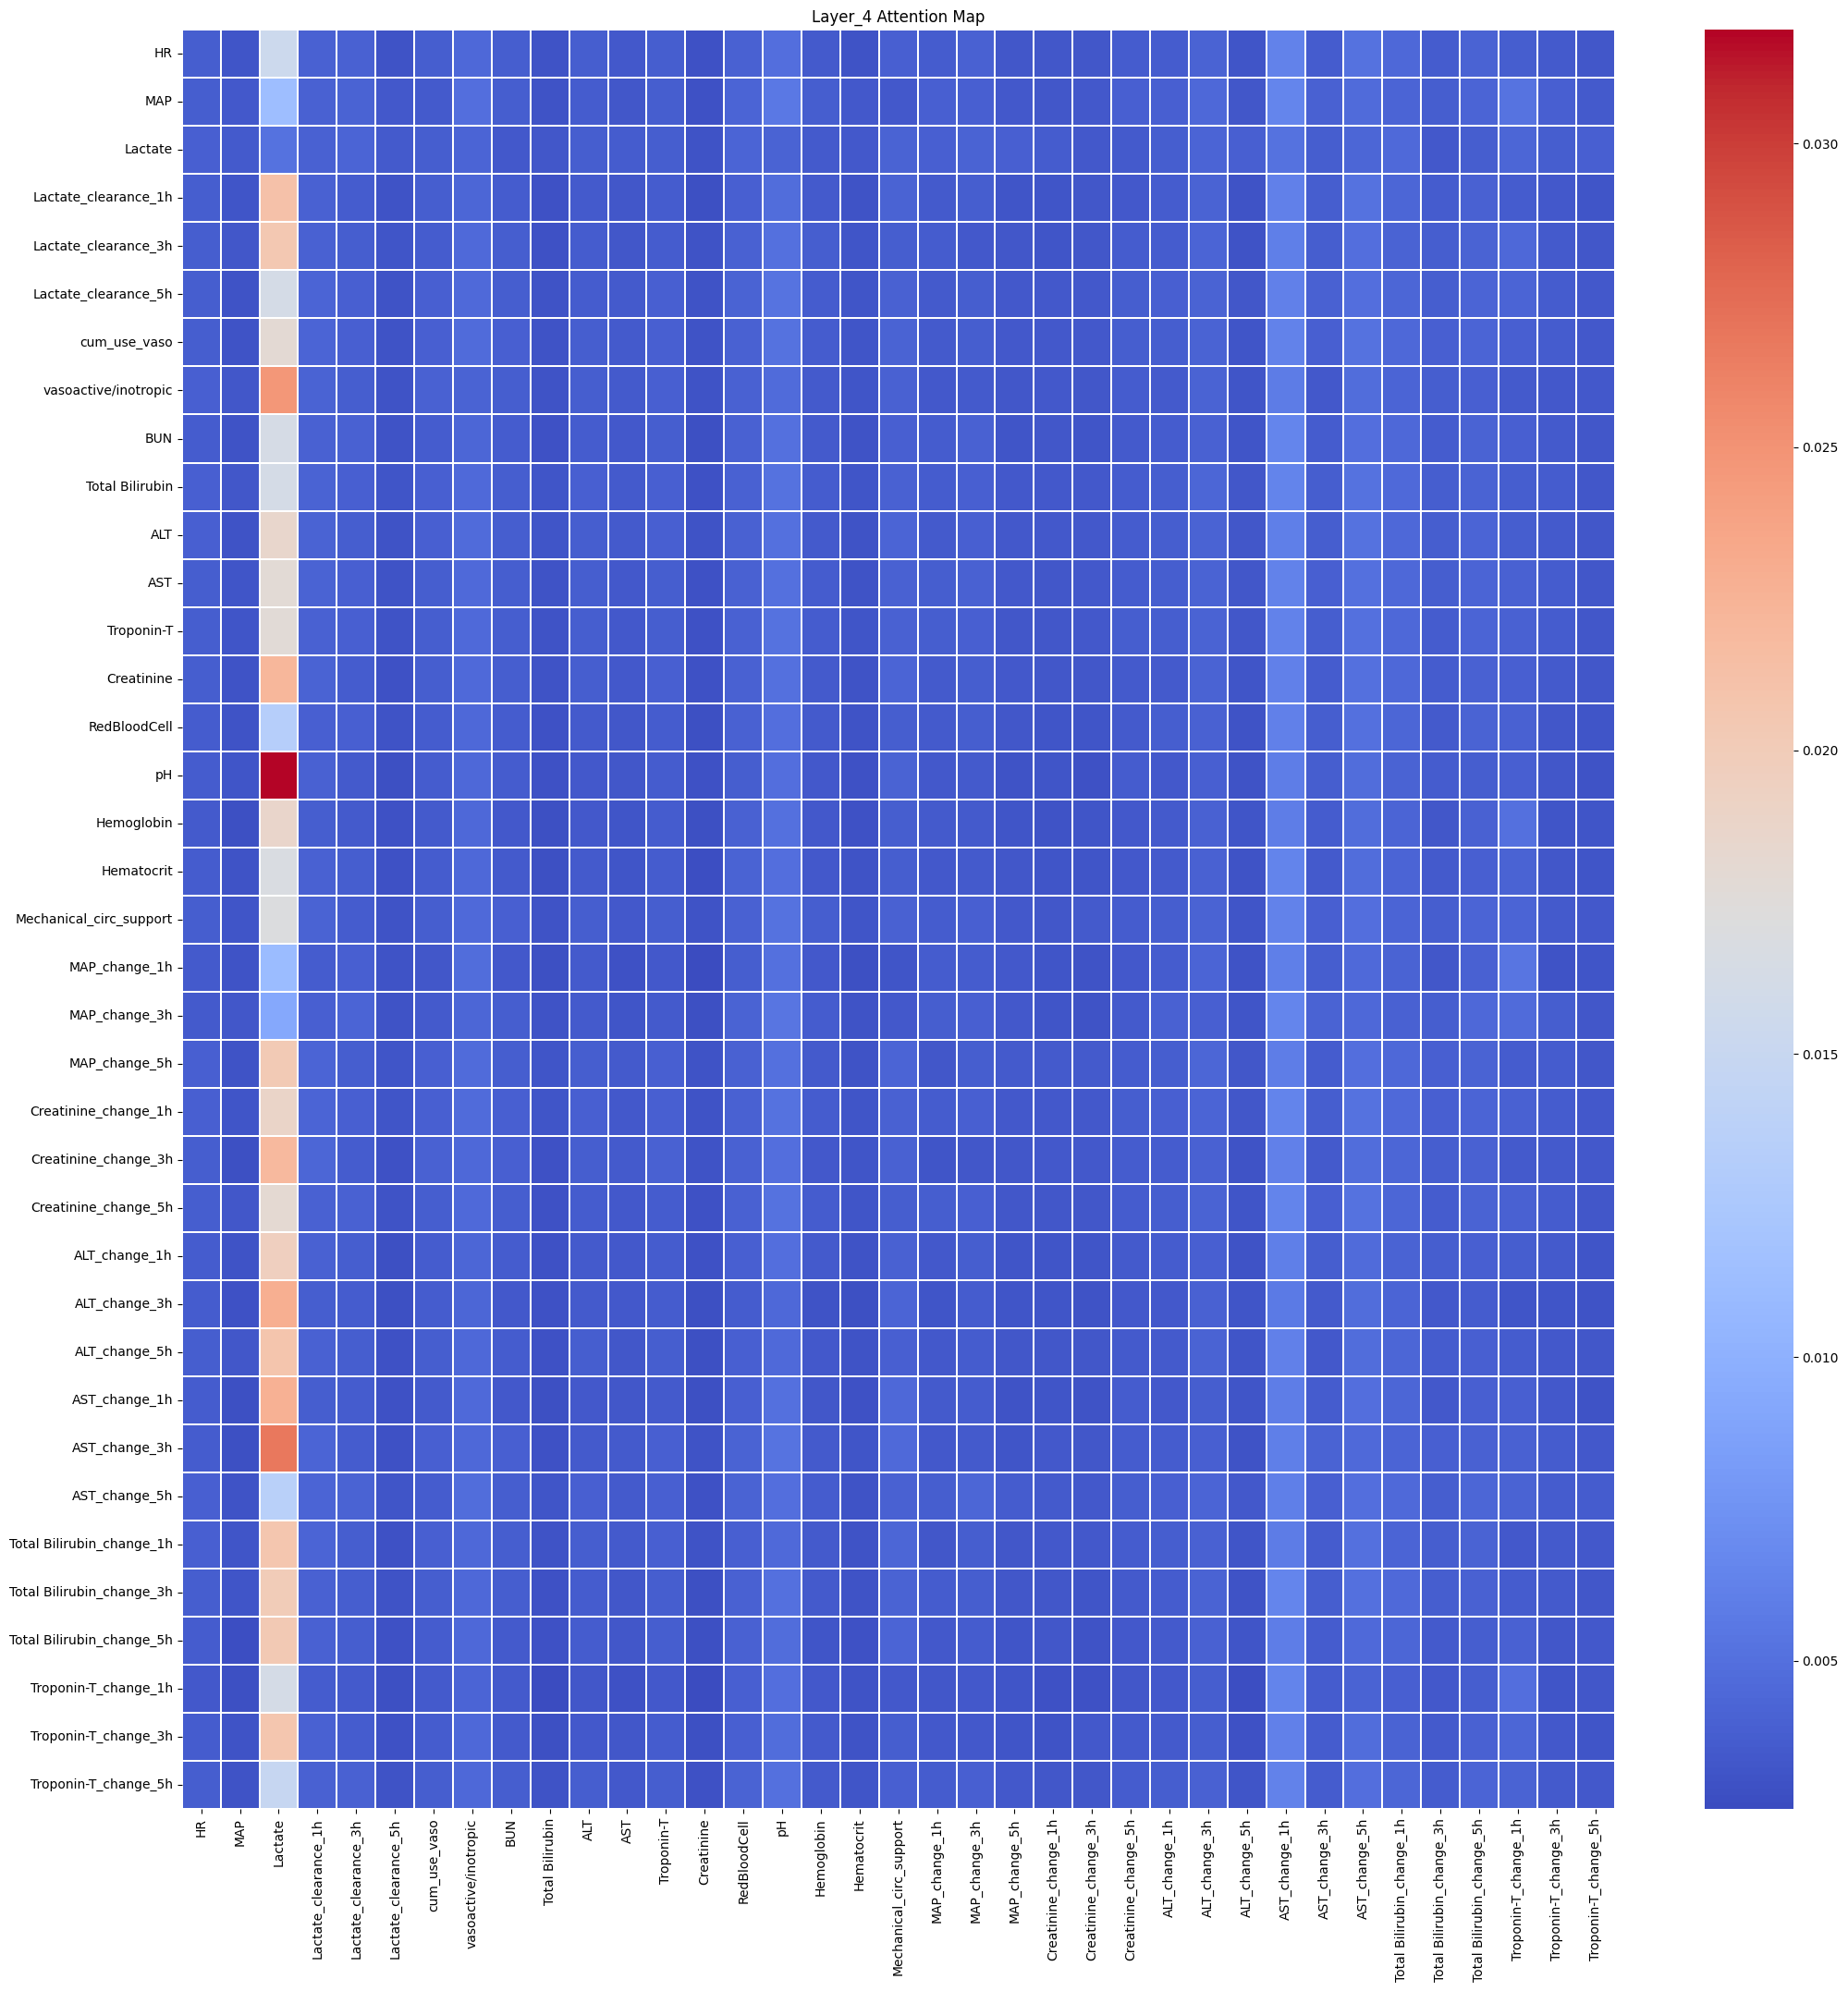

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

for layer in range(valid_att.shape[0]):
    plt.figure(figsize=(25, 25))
    plt.title(f'Layer_{layer+1} Attention Map')
    
    # 평균 계산
    avg_att = np.mean(valid_att[layer, :, :, :], axis=0) #(219, 219)
    avg_att_focus = avg_att[col_indx, :][:, col_indx]
    # Heatmap 그리기
    sns.heatmap(avg_att_focus, cmap='coolwarm', 
                xticklabels=focus_columns_names, yticklabels=focus_columns_names, linewidths=0.1)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)